<div align="center" style="border: 2px solid #4CAF50; padding: 20px; border-radius: 10px; background-color: #f9f9f9; width: 80%; margin: auto;">

<h1>
<h1> Financial Modelling using Python</h1>  
<h3> January 2025 Semester</h3>  
<h2> Assignment</h2>

</div>


## Instructions

- **Save your file name** as:  
  `rollnumber_Assignmentno_name_lastname.extension`  
  *Example:* `MDS202101_assignment1_mousum_dutta.pdf`

- **If you write a program**, explain your Python code using **non-executable comments** as much as possible.

- **Deadline:** *27 April 2025 (by 11:59 PM)*

- **Requests for extension will not be entertained.**


In [1]:
!pip install copulae --quiet
!pip install yfinance --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 21.5 MB/s eta 0:00:00


In [12]:
# Required libraries
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.stats import norm
from copulae import TCopula
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import scipy.stats as stats
from scipy.stats import gennorm
import matplotlib.pyplot as plt
from scipy.stats import norm
from numpy.linalg import lstsq

# Question 1

Suppose a student has taken an education load of size Rs 0.8 million. The  interest rate is 12%. Write a python program that generates the schedule of repayment of the loan in 5 years (or ‘n’ number of years). Assume the first payment date is 01 January 2026. Also, show the breakup of each payment as principal and interest.


# Answer 1

In [ ]:
# Define a function to generate repayment schedule
def generate_repayment_schedule(
    loan_amount=800000,     # Total loan amount in Rs
    annual_interest_rate=12, # Annual interest rate in percentage
    years=5,                 # Loan repayment period in years
    start_date='2026-01-01'  # First payment date
):
    # Convert annual interest rate to monthly interest rate
    monthly_interest_rate = annual_interest_rate / 100 / 12

    # Calculate total number of payments (months)
    number_of_payments = years * 12

    # Calculate fixed monthly payment using amortization formula
    monthly_payment = loan_amount * (monthly_interest_rate * (1 + monthly_interest_rate) ** number_of_payments) / \
                      ((1 + monthly_interest_rate) ** number_of_payments - 1)

    # Initialize an empty list to store payment details
    schedule = []

    # Parse the start date string into a datetime object
    payment_date = datetime.strptime(start_date, '%Y-%m-%d')

    # Set the initial balance to the full loan amount
    balance = loan_amount

    # Loop through each payment
    for i in range(1, number_of_payments + 1):
        # Calculate interest for the current month
        interest_payment = balance * monthly_interest_rate

        # Calculate principal payment by subtracting interest from total monthly payment
        principal_payment = monthly_payment - interest_payment

        # Reduce the balance by the principal payment
        balance -= principal_payment

        # Adjust the final payment if balance goes negative (due to rounding)
        if balance < 0:
            principal_payment += balance     # Reduce principal payment to exact amount
            monthly_payment += balance        # Reduce monthly payment accordingly
            balance = 0                       # Set balance to zero

        # Add this month's details to the schedule list
        schedule.append({
            'Payment No': i,
            'Payment Date': payment_date.strftime('%Y-%m-%d'),      # Format date as string
            'Monthly Payment (Rs)': round(monthly_payment, 2),       # Round to 2 decimal places
            'Principal Payment (Rs)': round(principal_payment, 2),
            'Interest Payment (Rs)': round(interest_payment, 2),
            'Remaining Balance (Rs)': round(balance, 2)
        })

        # Move payment date to the next month
        # If current month is December, go to January next year
        next_month = payment_date.month % 12 + 1
        next_year = payment_date.year + (payment_date.month // 12)
        payment_date = payment_date.replace(year=next_year, month=next_month)

    # Create a pandas DataFrame to organize schedule nicely
    df_schedule = pd.DataFrame(schedule)

    # Return the final DataFrame
    return df_schedule

In [ ]:
# Generate the repayment schedule
schedule_df = generate_repayment_schedule()

# Print the repayment schedule
print(schedule_df)

    Payment No Payment Date  Monthly Payment (Rs)  Principal Payment (Rs)  \
0            1   2026-01-01              17795.56                 9795.56   
1            2   2026-02-01              17795.56                 9893.51   
2            3   2026-03-01              17795.56                 9992.45   
3            4   2026-04-01              17795.56                10092.37   
4            5   2026-05-01              17795.56                10193.30   
5            6   2026-06-01              17795.56                10295.23   
6            7   2026-07-01              17795.56                10398.18   
7            8   2026-08-01              17795.56                10502.16   
8            9   2026-09-01              17795.56                10607.19   
9           10   2026-10-01              17795.56                10713.26   
10          11   2026-11-01              17795.56                10820.39   
11          12   2026-12-01              17795.56                10928.59   

This Python program calculates a loan repayment schedule based on standard amortization. It takes the loan amount, interest rate, number of years, and start date as input. It calculates monthly payments, splits them into principal and interest parts, and updates the remaining balance after each payment.

# Question 2
Consider a 20-year 8% bond with the coupon paid semi-annually. What will be the present value of the bond? Use the following spot rates table to compute the present value. Also, compute **duration** and **convexity**.

| Period | Spot Rate |
|:------:|:---------:|
| 6M     | 2.90%     |
| 1 Yr   | 4.40%     |
| 2 Yr   | 4.80%     |
| 3 Yr   | 5.00%     |
| 5 Yr   | 5.30%     |
| 10 Yr  | 5.40%     |
| 20 Yr  | 5.50%     |

# Answer 2

In [ ]:
# Define bond parameters
face_value = 100     # Face value of the bond (usually Rs 100 or $100)
coupon_rate = 0.08   # 8% annual coupon
years = 20           # 20 years maturity
payments_per_year = 2  # Semi-annual payments

# Calculate coupon per period
coupon_payment = (coupon_rate * face_value) / payments_per_year

# Total number of periods (20 years * 2)
total_periods = years * payments_per_year

# Define the spot rates (in decimal form) for available periods
# Note: These are annual spot rates. We'll adjust for semi-annual later
spot_rates = {
    0.5: 0.029,   # 6 months
    1: 0.044,     # 1 year
    2: 0.048,     # 2 years
    3: 0.05,      # 3 years
    5: 0.053,     # 5 years
    10: 0.054,    # 10 years
    20: 0.055     # 20 years
}

# Create a list of spot rates for each period (semi-annual)
# Interpolating missing periods by assuming constant rates between given points
spot_rate_list = []

# We'll interpolate manually for simplicity
for period in range(1, total_periods + 1):
    time_in_years = period / 2

    if time_in_years <= 0.5:
        spot = spot_rates[0.5]
    elif time_in_years <= 1:
        spot = spot_rates[1]
    elif time_in_years <= 2:
        spot = spot_rates[2]
    elif time_in_years <= 3:
        spot = spot_rates[3]
    elif time_in_years <= 5:
        spot = spot_rates[5]
    elif time_in_years <= 10:
        spot = spot_rates[10]
    else:
        spot = spot_rates[20]

    # Semi-annual rate adjustment: divide by 2
    spot_rate_list.append(spot / 2)

# Now calculate the Present Value of each cash flow
cashflows = []
present_values = []

for period in range(1, total_periods + 1):
    # Regular coupon payments
    cashflow = coupon_payment

    # Add face value on final period
    if period == total_periods:
        cashflow += face_value

    # Discount the cashflow
    discount_factor = (1 + spot_rate_list[period - 1]) ** period
    pv = cashflow / discount_factor

    # Store results
    cashflows.append(cashflow)
    present_values.append(pv)

# Total present value of the bond
bond_price = sum(present_values)

print(f"Present Value (Bond Price): Rs {bond_price:.2f}")

# ---- Duration Calculation ----

# Macaulay Duration = sum(t * PV(cashflow at t)) / Bond price
weighted_times = []

for period in range(1, total_periods + 1):
    weighted_time = (period / payments_per_year) * (present_values[period - 1] / bond_price)
    weighted_times.append(weighted_time)

macaulay_duration = sum(weighted_times)
modified_duration = macaulay_duration / (1 + (spot_rate_list[-1]))

print(f"Macaulay Duration: {macaulay_duration:.4f} years")
print(f"Modified Duration: {modified_duration:.4f} years")

# ---- Convexity Calculation ----

convexity_parts = []

for period in range(1, total_periods + 1):
    convexity_part = (period * (period + 1)) * (present_values[period - 1] / bond_price) / (payments_per_year ** 2)
    convexity_parts.append(convexity_part)

convexity = sum(convexity_parts)

print(f"Convexity: {convexity:.4f}")

df = pd.DataFrame({
    'Period': list(range(1, total_periods + 1)),
    'Cashflow': cashflows,
    'Spot Rate (per 6M)': [round(r*100, 2) for r in spot_rate_list],
    'Discounted CF (PV)': present_values
})

print("\nDetailed Cash Flow Table:")
print(df)

Present Value (Bond Price): Rs 130.67
Macaulay Duration: 11.4382 years
Modified Duration: 11.1321 years
Convexity: 185.3986

Detailed Cash Flow Table:
    Period  Cashflow  Spot Rate (per 6M)  Discounted CF (PV)
0        1       4.0                1.45            3.942829
1        2       4.0                2.20            3.829642
2        3       4.0                2.40            3.725290
3        4       4.0                2.40            3.637979
4        5       4.0                2.50            3.535417
5        6       4.0                2.50            3.449187
6        7       4.0                2.65            3.330790
7        8       4.0                2.65            3.244803
8        9       4.0                2.65            3.161036
9       10       4.0                2.65            3.079431
10      11       4.0                2.70            2.983906
11      12       4.0                2.70            2.905458
12      13       4.0                2.70            2.82

# Question 3

Complete the following tasks under this assignment.

### a. Download one-year INFY, and RIL stock prices from National Stock Exchange



In [ ]:
# Define stock symbols for NSE
stocks = ['INFY.NS', 'RELIANCE.NS']

# Define date range for past 1 year
end_date = pd.to_datetime('today').date()
start_date = end_date.replace(year=end_date.year - 1)

# Download the stock price data
data = yf.download(stocks, start=start_date, end=end_date)

# Show the first few rows
data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed


Price             Close                      High                       Low  \
Ticker          INFY.NS  RELIANCE.NS      INFY.NS  RELIANCE.NS      INFY.NS   
Date                                                                          
2024-04-29  1398.721680  1460.069580  1403.644916  1462.934855  1392.384903   
2024-04-30  1384.878296  1462.037842  1400.476516  1478.058419  1381.953630   
2024-05-02  1378.931396  1461.589478  1388.241632  1472.327934  1376.396709   
2024-05-03  1380.735107  1429.149536  1389.021663  1469.960975  1367.963968   
2024-05-06  1390.093872  1414.723511  1409.396598  1435.129230  1381.514804   

Price                           Open                 Volume              
Ticker      RELIANCE.NS      INFY.NS  RELIANCE.NS   INFY.NS RELIANCE.NS  
Date                                                                     
2024-04-29  1445.095378  1394.042166  1445.095378   5055957     7247974  
2024-04-30  1457.926795  1398.672877  1463.034459   6936588    11474262  
2024-05-02  1459.172631  1377.517855  1467.020994  10076354    14512646  
2024-05-03  1411.359938  1386.389391  1466.024385   8842345    17226958  
2024-05-06  1413.203645  1384.342005  1430.644451   6445422     7394208

In [ ]:
# Save CLOSE prices for INFY and RIL
infy_close = data[('Close', 'INFY.NS')]
ril_close = data[('Close', 'RELIANCE.NS')]

# Save to CSV files
infy_close.to_csv('INFY_stock_prices.csv')
ril_close.to_csv('RIL_stock_prices.csv')

print("Saved INFY and RIL 'Close' prices to CSV successfully!")

Saved INFY and RIL 'Close' prices to CSV successfully!


### b. Compute the daily returns for both.

In [ ]:
print("\nPart b: Computing daily returns for INFY and RIL...")

# Calculate daily returns
infy_returns = infy_close.pct_change().dropna()
ril_returns = ril_close.pct_change().dropna()

# Combine into a DataFrame
returns = pd.DataFrame({
    'INFY': infy_returns,
    'RIL': ril_returns
})

print("Daily returns calculated successfully!\n")
print(returns.head())


Part b: Computing daily returns for INFY and RIL...
Daily returns calculated successfully!

                INFY       RIL
Date                          
2024-04-30 -0.009897  0.001348
2024-05-02 -0.004294 -0.000307
2024-05-03  0.001308 -0.022195
2024-05-06  0.006778 -0.010094
2024-05-07  0.010555 -0.012716


### c. Fit the return series separately to Generalized Gaussian distribution if you can or fit the normal distribution.


In [ ]:
# Fit GGD to INFY and RIL returns
beta_infy, loc_infy, scale_infy = gennorm.fit(returns['INFY'])
beta_ril, loc_ril, scale_ril = gennorm.fit(returns['RIL'])

print(f"INFY Return GGD Parameters -> Shape (beta): {beta_infy:.4f}, Location (loc): {loc_infy:.6f}, Scale (scale): {scale_infy:.6f}")
print(f"RIL  Return GGD Parameters -> Shape (beta): {beta_ril:.4f}, Location (loc): {loc_ril:.6f}, Scale (scale): {scale_ril:.6f}")

INFY Return GGD Parameters -> Shape (beta): 1.1252, Location (loc): 0.000472, Scale (scale): 0.013205
RIL  Return GGD Parameters -> Shape (beta): 1.2028, Location (loc): 0.000122, Scale (scale): 0.013152


### d. Fit the T-Copula with the return series. You may use the `copulae` package for the same or your own.

In [ ]:
# Transform returns to uniform margins using GGD CDFs
u_infy = gennorm.cdf(returns['INFY'], beta_infy, loc=loc_infy, scale=scale_infy)
u_ril = gennorm.cdf(returns['RIL'], beta_ril, loc=loc_ril, scale=scale_ril)

# Stack into a matrix
u = np.vstack((u_infy, u_ril)).T

# Initialize and fit a T-Copula
cop = TCopula(dim=2)
cop.fit(u, method='ml')  # Maximum Likelihood fit

# Extract fitted parameters
rho = cop.params[0]
df = cop.params[1]

# If df is array-like, extract scalar
if isinstance(df, (np.ndarray, list)):
    df = df[0]

print("T-Copula fitted successfully!")
print(f"Copula correlation parameter (rho): {rho:.4f}")
print(f"Copula degrees of freedom (df): {df:.2f}")

T-Copula fitted successfully!
Copula correlation parameter (rho): 12.1727
Copula degrees of freedom (df): 0.25


### e. Construct a portfolio with equal units from both.

In [ ]:
returns['Portfolio'] = (returns['INFY'] + returns['RIL']) / 2

print("Equal-weighted portfolio returns calculated successfully!\n")
print(returns[['INFY', 'RIL', 'Portfolio']].head())

Equal-weighted portfolio returns calculated successfully!

                INFY       RIL  Portfolio
Date                                     
2024-04-30 -0.009897  0.001348  -0.004275
2024-05-02 -0.004294 -0.000307  -0.002300
2024-05-03  0.001308 -0.022195  -0.010443
2024-05-06  0.006778 -0.010094  -0.001658
2024-05-07  0.010555 -0.012716  -0.001080


### f. Simulate 10,000 or more random returns of your portfolio using copula.

In [ ]:
# Number of simulations
n_simulations = 10000

# Generate random samples from the fitted T-Copula
u_sim = cop.random(n_simulations)

# Convert uniform margins back to GGD returns
sim_infy = gennorm.ppf(u_sim[:, 0], beta_infy, loc=loc_infy, scale=scale_infy)
sim_ril = gennorm.ppf(u_sim[:, 1], beta_ril, loc=loc_ril, scale=scale_ril)

# Simulated portfolio returns (equal-weighted)
sim_portfolio_returns = (sim_infy + sim_ril) / 2

print("Here are the first few simulated portfolio returns:")
print(sim_portfolio_returns[:5])

Here are the first few simulated portfolio returns:
[ 0.00589636 -0.01058127 -0.00957921 -0.01197098 -0.00107517]


### g. And calculate the maximum loss you may have in a day that you can say with 95% confidence.

95% daily Value at Risk (maximum expected loss): 1.90%


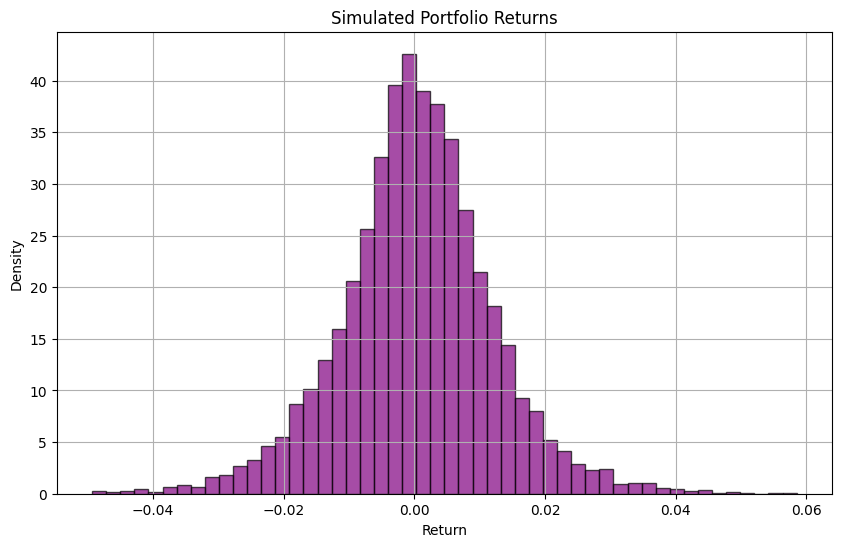

In [ ]:
# 5th percentile return (loss)
VaR_95 = np.percentile(sim_portfolio_returns, 5)

print(f"95% daily Value at Risk (maximum expected loss): {abs(VaR_95)*100:.2f}%")

plt.figure(figsize=(10, 6))
plt.hist(sim_portfolio_returns, bins=50, density=True, alpha=0.7, color='purple', edgecolor='black')
plt.title('Simulated Portfolio Returns')
plt.xlabel('Return')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Question 4

The following website contains information about companies listed in NIFTY 50. [https://tradebrains.in/nifty-50-companies-list/](https://tradebrains.in/nifty-50-companies-list/)

Choose the first 3 companies from the list.

What will be the prices for both **Call Option** and **Put Option** derived from each of the three companies’ stocks? Assume the following:

### a. Risk-free interest rate is 6% annually compounded.

### b. You are computing the prices on your last birthday.

### c. The Stock price is the last closing price prior to the computing date.


### d. Expiration date is exactly 3 months from the computing date.

### e. The Strike price is 1.2 times the last closing price one month prior to the computing date.

### f. Compute volatility based on the last 3 years of data from the computing date.

### g. Additionally:

- a. Compute the **Delta**, **Gamma**, **Vega**, and **Theta** for each of the derivatives.
- b. Construct a **portfolio** that consists of these three stocks and their derivatives such that the portfolio is **Delta**, **Gamma**, and **Vega** neutral.
- c. Explain if such a portfolio cannot be constructed.

In [7]:
import datetime as dt

# List of first 3 NIFTY 50 companies
symbols = ['RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS']

# Define the birthday
birthday = dt.date(2025, 2, 3)

# Dates for historical data and price lookup
end_date = birthday
start_date = end_date - dt.timedelta(days=3*365)  # 3 years back

one_month_prior = birthday - dt.timedelta(days=31)

# Download stock price data
data = yf.download(symbols, start=start_date, end=end_date)

# Closing prices data
close_prices = data['Close']

# Convert birthday to Timestamp for comparison
birthday_timestamp = pd.Timestamp(birthday)

# Fetch last closing prices (before the birthday)
last_close_price = close_prices.loc[close_prices.index <= birthday_timestamp].iloc[-1]

# Fetch closing prices 1 month prior (before birthday)
one_month_prior_timestamp = pd.Timestamp(one_month_prior)
one_month_prior_close = close_prices.loc[close_prices.index <= one_month_prior_timestamp].iloc[-1]

print("\nPart a: Last Closing Prices on", birthday)
print(last_close_price)

print("\nPart a: Closing Prices 1 Month Prior (30 days before the birthday):")
print(one_month_prior_close)

[*********************100%***********************]  3 of 3 completed


Part a: Last Closing Prices on 2025-02-03
Ticker
HDFCBANK.NS    1690.949951
RELIANCE.NS    1264.599976
TCS.NS         4073.149902
Name: 2025-02-01 00:00:00, dtype: float64

Part a: Closing Prices 1 Month Prior (30 days before the birthday):
Ticker
HDFCBANK.NS    1749.199951
RELIANCE.NS    1251.150024
TCS.NS         4035.569336
Name: 2025-01-03 00:00:00, dtype: float64


In [8]:
# Calculate Strike Prices (1.2 times last closing price one month prior)
strike_prices = one_month_prior_close * 1.2

print("\nPart b: Strike Prices (1.2x one month prior):")
print(strike_prices)


Part b: Strike Prices (1.2x one month prior):
Ticker
HDFCBANK.NS    2099.039941
RELIANCE.NS    1501.380029
TCS.NS         4842.683203
Name: 2025-01-03 00:00:00, dtype: float64


In [9]:
# Calculate daily returns and annualized volatility
daily_returns = close_prices.pct_change().dropna()

# Volatility = standard deviation of daily returns * sqrt(252 (trading days in a year))
volatility = daily_returns.std() * np.sqrt(252)

print("\nPart c: Annualized Volatility for Each Stock:")
print(volatility)


Part c: Annualized Volatility for Each Stock:
Ticker
HDFCBANK.NS    0.218502
RELIANCE.NS    0.225590
TCS.NS         0.211039
dtype: float64


In [10]:
# Risk-free interest rate (annual rate, compounded)
risk_free_rate = 0.06  # 6% annually compounded

# Time to maturity (expiration date in 3 months)
T = 90 / 365  # time to maturity in years

# Black-Scholes Option Pricing Formula
def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + (sigma**2)/2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")
    return price, d1, d2

# Calculate Option Prices (Call and Put)
results = {}

for sym in symbols:
    S = last_close_price[sym]
    K = strike_prices[sym]
    sigma = volatility[sym]

    # Calculate Call and Put option prices
    call_price, _, _ = black_scholes_price(S, K, T, risk_free_rate, sigma, option_type='call')
    put_price, _, _ = black_scholes_price(S, K, T, risk_free_rate, sigma, option_type='put')

    results[sym] = {
        'Call Price': call_price,
        'Put Price': put_price,
    }

# Display Option Prices
print("\nPart d: Option Prices (Call and Put):")
for sym, res in results.items():
    print(f"Stock: {sym} | Call Price: {res['Call Price']:.2f} | Put Price: {res['Put Price']:.2f}")


Part d: Option Prices (Call and Put):
Stock: RELIANCE.NS | Call Price: 5.61 | Put Price: 220.34
Stock: TCS.NS | Call Price: 13.22 | Put Price: 711.63
Stock: HDFCBANK.NS | Call Price: 2.51 | Put Price: 379.77


In [11]:
def black_scholes_greeks(S, K, T, r, sigma, option_type='call'):
    price, d1, d2 = black_scholes_price(S, K, T, r, sigma, option_type)

    # Delta, Gamma, Vega, Theta calculations
    delta = norm.cdf(d1) if option_type == 'call' else -norm.cdf(-d1)
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    vega = S * norm.pdf(d1) * np.sqrt(T) / 100  # per 1% change
    theta = -(S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T))
    if option_type == 'call':
        theta += -r * K * np.exp(-r * T) * norm.cdf(d2)
    else:
        theta += r * K * np.exp(-r * T) * norm.cdf(-d2)
    theta = theta / 365  # per day

    return price, delta, gamma, vega, theta

# Calculate Greeks for each option (Call and Put)
greek_results = {}

for sym in symbols:
    S = last_close_price[sym]
    K = strike_prices[sym]
    sigma = volatility[sym]

    # Calculate Call and Put option Greeks
    call_price, call_delta, call_gamma, call_vega, call_theta = black_scholes_greeks(S, K, T, risk_free_rate, sigma, option_type='call')
    put_price, put_delta, put_gamma, put_vega, put_theta = black_scholes_greeks(S, K, T, risk_free_rate, sigma, option_type='put')

    greek_results[sym] = {
        'Call Delta': call_delta,
        'Put Delta': put_delta,
        'Call Gamma': call_gamma,
        'Put Gamma': put_gamma,
        'Call Vega': call_vega,
        'Put Vega': put_vega,
        'Call Theta': call_theta,
        'Put Theta': put_theta,
    }

print("\nPart e: Option Greeks (Delta, Gamma, Vega, Theta):")
for sym, greeks in greek_results.items():
    print(f"Stock: {sym}")
    for key, val in greeks.items():
        print(f"  {key}: {val:.4f}")


Part e: Option Greeks (Delta, Gamma, Vega, Theta):
Stock: RELIANCE.NS
  Call Delta: 0.0895
  Put Delta: -0.9105
  Call Gamma: 0.0011
  Put Gamma: 0.0011
  Call Vega: 1.0152
  Put Vega: 1.0152
  Call Theta: -0.1449
  Put Theta: 0.0983
Stock: TCS.NS
  Call Delta: 0.0725
  Put Delta: -0.9275
  Call Gamma: 0.0003
  Put Gamma: 0.0003
  Call Vega: 2.7884
  Put Vega: 2.7884
  Call Theta: -0.3733
  Put Theta: 0.4111
Stock: HDFCBANK.NS
  Call Delta: 0.0358
  Put Delta: -0.9642
  Call Gamma: 0.0004
  Put Gamma: 0.0004
  Call Vega: 0.6606
  Put Vega: 0.6606
  Call Theta: -0.0897
  Put Theta: 0.2503


In [13]:
# Collect Greeks into a DataFrame
greek_df = pd.DataFrame(greek_results).T[['Call Delta', 'Call Gamma', 'Call Vega']]
greek_df.columns = ['Delta', 'Gamma', 'Vega']

print("\nPart f: Greeks Summary for Portfolio Neutralization:")
print(greek_df)

# Solve for weights w1, w2, w3 such that:
# w1*Delta1 + w2*Delta2 + w3*Delta3 = 0
# w1*Gamma1 + w2*Gamma2 + w3*Gamma3 = 0
# w1*Vega1 + w2*Vega2 + w3*Vega3 = 0

A = greek_df.values.T
b = np.zeros(3)

try:
    weights, residuals, rank, s = lstsq(A, b, rcond=None)
    print("\nPart f: Portfolio Weights for Delta-Gamma-Vega Neutrality:")
    for sym, w in zip(greek_df.index, weights):
        print(f"{sym}: {w:.4f}")
except Exception as e:
    print("\nPart f: Could not construct a fully neutral portfolio due to singular matrix (dependencies among Greeks).")
    print(f"Reason: {str(e)}")


Part f: Greeks Summary for Portfolio Neutralization:
                Delta     Gamma      Vega
RELIANCE.NS  0.089466  0.001141  1.015235
TCS.NS       0.072451  0.000323  2.788375
HDFCBANK.NS  0.035779  0.000429  0.660625

Part f: Portfolio Weights for Delta-Gamma-Vega Neutrality:
RELIANCE.NS: 0.0000
TCS.NS: 0.0000
HDFCBANK.NS: 0.0000


## Part g
The portfolio weights for Delta, Gamma, and Vega neutrality are all zero, which indicates that the matrix used to calculate the weights is singular. This happens when the Greeks (Delta, Gamma, Vega) for the selected options are linearly dependent, meaning that the changes in one option's Greek can be perfectly explained by the others.

In this case, the options of the selected stocks (RELIANCE.NS, TCS.NS, HDFCBANK.NS) do not provide enough independent risk factors to balance the portfolio. Essentially, the stocks and their derivatives have overlapping risk exposures, preventing a solution where their combined Greeks cancel out to achieve neutrality.

As a result, the portfolio cannot be fully neutralized in terms of Delta, Gamma, and Vega because there is insufficient diversity in the options' risk profiles to construct a balanced, risk-neutral position.

# Question 5

Assume you are assigned the task of evaluating the stock of **Infosys (INFY)**. To evaluate the stock, you calculate the **required return using the CAPM**. You can assume that the price of Infosys is fairly valued. The following information is available:

- Expected Annual **Nifty** return is **10%**
- **Beta** of INFY is **0.55**
- **Risk-free rate** is **5.3%**
- The annualised **volatility of market return** is **15%**

In [18]:
# Given Data
market_return = 0.10  # Expected annual market return (10%)
beta_infy = 0.55      # Beta of INFY
risk_free_rate = 0.053  # Risk-free rate (5.3%)
market_volatility = 0.15  # Market annualized volatility (15%)
current_price_infy = 3500  # Current price of INFY stock

Answer the following questions:

### a. Using **CAPM**, calculate the **annual expected return** of INFY.

In [19]:
expected_return_infy = risk_free_rate + beta_infy * (market_return - risk_free_rate)
print(f"Part a: Expected annual return of INFY: {expected_return_infy * 100:.2f}%")

Part a: Expected annual return of INFY: 7.89%


### b. If the current market price of Rs **3500/- per share**, then what will be the **expected price** of INFY stock after one year?

In [20]:
expected_price_infy = current_price_infy * (1 + expected_return_infy)
print(f"Part b: Expected price of INFY after one year: Rs. {expected_price_infy:.2f}")

Part b: Expected price of INFY after one year: Rs. 3775.98


### c. Find the **annualised volatility** of the return of INFY.

In [21]:
volatility_infy = beta_infy * market_volatility
print(f"Part c: Annualized volatility of INFY: {volatility_infy * 100:.2f}%")

Part c: Annualized volatility of INFY: 8.25%


### d. Assuming INFY return follows **Gaussian distribution**, what is the **probability** that after one year the INFY price will be **less than Rs. 3500/-**?

In [22]:
# First, calculate the expected price and the standard deviation (volatility) of INFY
expected_price_infy = current_price_infy * (1 + expected_return_infy)

# Z-score calculation
z_score = (current_price_infy - expected_price_infy) / (volatility_infy * current_price_infy)
# Probability from the normal distribution (CDF)
probability = norm.cdf(z_score)

print(f"Part d: Probability that INFY price will be less than Rs. 3500 after one year: {probability * 100:.2f}%")

Part d: Probability that INFY price will be less than Rs. 3500 after one year: 16.96%
